In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
from pathlib import Path
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
# DATA
DATA_ROOT = "/kaggle/input/temporal-jersey-number-dataset/temporal_jersey_nr_recognition_dataset_subset"
IMAGE_SIZE = (96, 48)     # (H, W)
MAX_FRAMES = 20

# TRAINING
BATCH_SIZE = 2
EPOCHS = 20
LR = 1e-3

# REPRODUCIBILITY
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [6]:
def is_anchor(filename):
    return "anchor" in filename.lower()

def load_image(path):
    return Image.open(path).convert("RGB")

In [7]:
class JerseySequenceDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_frames=20):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.max_frames = max_frames
        self.samples = []
        self._build_index()

    def _build_index(self):
        for class_folder in sorted(self.root_dir.iterdir()):
            if not class_folder.is_dir():
                continue

            label = int(class_folder.name)
            tens, ones = label // 10, label % 10

            for seq_folder in class_folder.iterdir():
                zero_folder = seq_folder / "0"
                if not zero_folder.exists():
                    continue

                frames = [
                    p for p in zero_folder.iterdir()
                    if p.suffix.lower() == ".jpg" and not is_anchor(p.name)
                ]

                if len(frames) == 0:
                    continue

                self.samples.append({
                    "frames": sorted(frames),
                    "tens": tens,
                    "ones": ones
                })

        print(f"Loaded {len(self.samples)} sequences")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        frames = sample["frames"]

        # uniform temporal sampling
        if len(frames) >= self.max_frames:
            idxs = np.linspace(0, len(frames)-1, self.max_frames).astype(int)
            frames = [frames[i] for i in idxs]
        else:
            frames = frames + [frames[-1]] * (self.max_frames - len(frames))

        imgs = []
        for f in frames:
            img = load_image(f)
            if self.transform:
                img = self.transform(img)
            imgs.append(img)

        imgs = torch.stack(imgs)  # (T, C, H, W)

        return imgs, sample["tens"], sample["ones"]


In [8]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

dataset = JerseySequenceDataset(
    DATA_ROOT,
    transform=transform,
    max_frames=MAX_FRAMES
)


Loaded 1881 sequences


In [9]:
indices = list(range(len(dataset)))
random.shuffle(indices)

n = len(indices)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds   = torch.utils.data.Subset(dataset, val_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train sequences: {len(train_ds)}")
print(f"Val sequences:   {len(val_ds)}")
print(f"Test sequences:  {len(test_ds)}")


Train sequences: 1316
Val sequences:   282
Test sequences:  283


In [10]:
class FrameEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

    def forward(self, x):
        x = self.net(x)
        return x.view(x.size(0), -1)  # (B, 128)


In [11]:
class TemporalJerseyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = FrameEncoder()

        self.gru = nn.GRU(
            input_size=128,
            hidden_size=128,
            batch_first=True,
            dropout=0.3
        )

        # digit-specific projection heads
        self.tens_proj = nn.Linear(128, 64)
        self.ones_proj = nn.Linear(128, 64)

        self.tens_head = nn.Linear(64, 10)
        self.ones_head = nn.Linear(64, 10)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)

        feats = self.encoder(x)
        feats = feats.view(B, T, -1)

        out, _ = self.gru(feats)
        h = out.mean(dim=1)

        tens_feat = torch.relu(self.tens_proj(h))
        ones_feat = torch.relu(self.ones_proj(h))

        return self.tens_head(tens_feat), self.ones_head(ones_feat)


In [12]:
model = TemporalJerseyNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

print("Total parameters:",
      sum(p.numel() for p in model.parameters()))


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Total parameters: 210580


In [13]:
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, tens, ones in train_loader:
        imgs, tens, ones = imgs.to(device), tens.to(device), ones.to(device)

        optimizer.zero_grad()
        tens_out, ones_out = model(imgs)
        loss = 0.7 * criterion(tens_out, tens) + 1.3 * criterion(ones_out, ones)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, tens, ones in val_loader:
            imgs, tens, ones = imgs.to(device), tens.to(device), ones.to(device)
            tens_out, ones_out = model(imgs)
            val_loss += (criterion(tens_out, tens)
                         + criterion(ones_out, ones)).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train: {train_loss:.4f} | Val: {val_loss:.4f}")

Epoch [1/20] Train: 2.0645 | Val: 1.6011
Epoch [2/20] Train: 1.9803 | Val: 1.5294
Epoch [3/20] Train: 1.9420 | Val: 1.4922
Epoch [4/20] Train: 1.9189 | Val: 1.4577
Epoch [5/20] Train: 1.8900 | Val: 1.4067
Epoch [6/20] Train: 1.8695 | Val: 1.4782
Epoch [7/20] Train: 1.8141 | Val: 1.4525
Epoch [8/20] Train: 1.8203 | Val: 1.3913
Epoch [9/20] Train: 1.7809 | Val: 1.4070
Epoch [10/20] Train: 1.7508 | Val: 1.5198
Epoch [11/20] Train: 1.7627 | Val: 1.3971
Epoch [12/20] Train: 1.6820 | Val: 1.4148
Epoch [13/20] Train: 1.6165 | Val: 1.4336
Epoch [14/20] Train: 1.5709 | Val: 1.3904
Epoch [15/20] Train: 1.5671 | Val: 1.3307
Epoch [16/20] Train: 1.5683 | Val: 1.3857
Epoch [17/20] Train: 1.5037 | Val: 1.3802
Epoch [18/20] Train: 1.5256 | Val: 1.4890
Epoch [19/20] Train: 1.5038 | Val: 1.3890
Epoch [20/20] Train: 1.5065 | Val: 1.4192


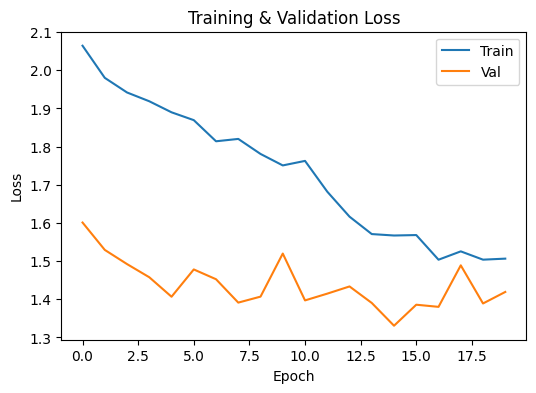

In [14]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [16]:
def evaluate_detailed(model, loader):
    model.eval()
    tens_correct = ones_correct = both_correct = total = 0

    with torch.no_grad():
        for imgs, tens, ones in loader:
            imgs, tens, ones = imgs.to(device), tens.to(device), ones.to(device)

            tens_out, ones_out = model(imgs)
            tens_pred = tens_out.argmax(1)
            ones_pred = ones_out.argmax(1)

            tens_correct += (tens_pred == tens).sum().item()
            ones_correct += (ones_pred == ones).sum().item()
            both_correct += ((tens_pred == tens) &
                             (ones_pred == ones)).sum().item()
            total += tens.size(0)

    return {
        "tens_acc": tens_correct / total,
        "ones_acc": ones_correct / total,
        "full_acc": both_correct / total
    }


In [17]:
print("\nVALIDATION SET RESULTS")
val_metrics = evaluate_detailed(model, val_loader)
for k, v in val_metrics.items():
    print(f"{k}: {v*100:.2f}%")

print("\nTEST SET RESULTS (UNSEEN DATA)")
test_metrics = evaluate_detailed(model, test_loader)
for k, v in test_metrics.items():
    print(f"{k}: {v*100:.2f}%")



VALIDATION SET RESULTS
tens_acc: 93.62%
ones_acc: 47.52%
full_acc: 46.45%

TEST SET RESULTS (UNSEEN DATA)
tens_acc: 87.63%
ones_acc: 42.05%
full_acc: 40.64%
